In [6]:

import os
import sys
import matplotlib.pyplot as plt

# Use os.getcwd() to get the current working directory
main_directory = os.getcwd()
parent_directory = os.path.dirname(main_directory)
parent_directory = os.path.dirname(parent_directory)


# Define the subdirectories you want to add to sys.path
subdirs = ['MaSeq', 'marcos_client']

# Add the subdirectories to sys.path
for subdir in subdirs:
    full_path = os.path.join(parent_directory, subdir)
    sys.path.append(full_path)
#******************************************************************************

In [36]:


from seq.utils import sort_data_implicit, plot_nd, ifft_2d, combine_coils
import pypulseq as pp
import numpy as np
import seq.mriBlankSeq as blankSeq   
import configs.units as units
import scipy.signal as sig
import experiment_multifreq as ex
import configs.hw_config_pseq as hw
from flocra_pulseq.interpreter_pseq import PseqInterpreter
from pypulseq.convert import convert
class SPRITER2dSEQ(blankSeq.MRIBLANKSEQ):
    def __init__(self, nScans=None, larmorFreq=None, rfExFA=None, repetitionTime=None,
                                           rfExTime=None, echoTime=None, nPoints=None, riseTime=None,
                 SpoilingTimeAfterRising=None, fov=None, bandwidth=None,
                 SamplingPoints=None, shimming=None, txChannel=None, rxChannel=None,
                 axesOrientation=None):
        super(SPRITER2dSEQ, self).__init__()
        # Input the parameters

        self.nScans = np.array(nScans)
        self.larmorFreq = np.array(larmorFreq)
        self.rfExFA = np.array(rfExFA)
        self.repetitionTime = np.array(repetitionTime)
        self.rfExTime = np.array(rfExTime)
        self.echoTime = np.array(echoTime)
        self.nPoints = np.array(nPoints)
        self.riseTime = np.array(riseTime)
        self.SpoilingTimeAfterRising = np.array(SpoilingTimeAfterRising)
        self.fov = np.array(fov)
        self.bandwidth = np.array(bandwidth)
        self.SamplingPoints = np.array(SamplingPoints)
        self.shimming = np.array(shimming)
        self.txChannel = np.array(txChannel)
        self.rxChannel = np.array(rxChannel)
        self.axesOrientation = np.array(axesOrientation)


        self.addParameter(key='seqName', string='SpriteInfo', val='TSE')
        self.addParameter(key='nScans', string='Number of scans', val=nScans, field='SEQ')
        self.addParameter(key='larmorFreq', string='Larmor frequency (MHz)', val=larmorFreq, units=units.MHz, field='RF')
        self.addParameter(key='rfExFA', string='Excitation flip angle (deg)', val=rfExFA, field='RF')
        self.addParameter(key='repetitionTime', string='Repetition time (ms)', val=repetitionTime, units=units.ms, field='SEQ')
        self.addParameter(key='rfExTime', string='RF excitation time (us)', val=rfExTime, units=units.us, field='RF')
        self.addParameter(key='echoTime', string='Echo time (ms)', val=echoTime, units=units.ms, field='SEQ')
        self.addParameter(key='nPoints', string='Number of acquired points', val=nPoints, field='IM')
        self.addParameter(key='riseTime', string='Grad. Rise time (ms)', val=riseTime, units=units.ms, field='OTH')
        self.addParameter(key='SpoilingTimeAfterRising', string='Grad. soiling time after grad. rising (ms)', val=SpoilingTimeAfterRising, units=units.ms, field='OTH')
        self.addParameter(key='fov', string='FOV [x,y](mm)', val=fov, units=units.mm, field='IM')
        self.addParameter(key='bandwidth', string='Acquisition Bandwidth (kHz)', val=bandwidth, units=units.kHz, field='IM',
                                tip="The bandwidth of the acquisition (kHz). This value affects resolution and SNR.")
        self.addParameter(key='SamplingPoints', string='Sampling Points Number[x,y]', val=SamplingPoints, field='IM')
        self.addParameter(key='shimming', string='shimming', val=shimming, units=units.sh, field='OTH')
        self.addParameter(key='txChannel', string='Tx channel', val=txChannel, field='RF')
        self.addParameter(key='rxChannel', string='Rx channel', val=rxChannel, field='RF')
        self.addParameter(key='axesOrientation', string='Axes[rd,ph,sl]', val=axesOrientation, field='IM',
                          tip="0=x, 1=y, 2=z")
    def sequenceInfo(self):
        pass
        
    def sequenceTime(self):
        return (self.mapVals['repetitionTime'] *1e-3 * self.mapVals['SamplingPoints'][0] * self.mapVals['SamplingPoints'][1] * self.mapVals['nScans'] / 60)  # minutes

    def sequenceAtributes(self):
        super().sequenceAtributes()
        
    
    def sequenceRun(self, plotSeq=0, demo=False, standalone=False):
        init_gpa = False
        self.demo = demo
        self.plotSeq = plotSeq
        self.standalone = standalone

        max_grad_Hz = convert(from_value=hw.max_grad, from_unit='mT/m', gamma=hw.gammaB, to_unit='Hz/m')
        
        rfExTime_us = int(np.round(self.rfExTime * 1e6))
        assert rfExTime_us in hw.max_cpmg_rf_arr, f"RF excitation time '{rfExTime_us}' s is not found in the hw_config_pseq file; please search it in search_p90_pseq."
        
        max_rf_Hz = hw.max_cpmg_rf_arr[rfExTime_us] * 1e-6 * hw.gammaB
        self.flo_interpreter = PseqInterpreter(
            tx_warmup=10,  # Transmit chain warm-up time (us)
            rf_center=hw.larmorFreq * 1e6 ,  # Larmor frequency (Hz)
            rf_amp_max=max_rf_Hz,  # Maximum RF amplitude (Hz)
            grad_max=max_grad_Hz,  # Maximum gradient amplitude (Hz/m)
            grad_t=10,  # Gradient raster time (us)
            orientation=self.axesOrientation, # gradient orientation
            grad_eff=hw.gradFactor, # gradient coefficient of efficiency
            tx_ch = self.txChannel, # Transmit channel
            rx_ch = self.rxChannel, # Receive channel
            add_rx_points = 0, # Additional points for the receiver
            tx_t= 1229/122.88, # us
            grad_zero_end=False,
            use_multi_freq=False, # Use multi-frequency mode
            use_grad_preemphasis=False,
            grad_preemphasis_coeff={
                        'xx':( (np.array([0.383494796, 0.159428847, 0.06601789, 0.03040273]), 
                            np.array([384.543433, 4353.01123, 46948.52793, 485123.9174] ))),
                        'yy':( (np.array([0.383494796, 0.159428847, 0.06601789, 0.03040273]),
                            np.array([384.543433, 4353.01123, 46948.52793, 485123.9174] ))),
                        'zz':( (np.array([0.383494796, 0.159428847, 0.06601789, 0.03040273]),
                            np.array([384.543433, 4353.01123, 46948.52793, 485123.9174] ))),
                 },
            use_fir_decimation = (self.bandwidth < 30.007326007326007e3), # 30kHz
        )
        assert (self.txChannel == 0 or self.txChannel == 1)
        assert (self.rxChannel == 0 or self.rxChannel == 1)
        self.rxChName = 'rx0' if (self.rxChannel == 0) else 'rx1'
        self.mapVals['rxChName'] = 'rx0'

        self.system = pp.Opts(
            rf_dead_time=10 * 1e-6,  # Dead time between RF pulses (s)
            rf_ringdown_time= 10 * 1e-6,
            max_grad=60,  # Maximum gradient strength (mT/m)
            grad_unit='mT/m',  # Units of gradient strength
            max_slew=hw.max_slew_rate,  # Maximum gradient slew rate (mT/m/ms)
            slew_unit='mT/m/ms',  # Units of gradient slew rate
            grad_raster_time=hw.grad_raster_time,  # Gradient raster time (s)
            rise_time=self.riseTime,  # Gradient rise time (s)
            rf_raster_time=10e-6,
            block_duration_raster=1e-6,
            adc_raster_time=1/(122.88e6)
        )

        bw = self.bandwidth * 1e-6 # MHz
        bw_ov = bw
        sampling_period = 1 / bw_ov  # us, Dwell time

        if not self.demo:
            expt = ex.Experiment(
                lo_freq=hw.larmorFreq,  # Larmor frequency in MHz
                rx_t=sampling_period,  # Sampling time in us
                init_gpa=False,  # Whether to initialize GPA board (False for True)
                gpa_fhdo_offset_time=(1 / 0.2 / 3.1),  # GPA offset time calculation
                auto_leds=True  # Automatic control of LEDs (False or True)
            )
            sampling_period = expt.get_rx_ts()[0]  # us
            bw = 1 / sampling_period # / hw.oversamplingFactor  # MHz
            print("Acquisition bandwidth fixed to: %0.3f kHz" % (bw * 1e3))
            expt.__del__()
        self.mapVals['bw_MHz'] = bw
        self.mapVals['sampling_period_us'] = sampling_period
        self.mapVals['acqTime'] = self.nPoints / bw * 1e-3 # ms

        readout_duration = sampling_period * 1e-6 * self.nPoints

        readout_duration_rounded = np.ceil(sampling_period * self.nPoints / 10) * 10 * 1e-6
        if not self.demo:
            print(f'dwell time: {sampling_period} us, readout time: {readout_duration} s')
        
    
        delay_TE = np.round((self.echoTime - 0.5 * self.rfExTime - self.system.rf_ringdown_time) / self.system.block_duration_raster) * self.system.block_duration_raster
        delay_Spoiling_before_rising = np.round((self.repetitionTime - 0.5 * self.rfExTime - self.system.rf_dead_time 
             -self.riseTime - self.SpoilingTimeAfterRising - readout_duration_rounded) / self.system.block_duration_raster) * self.system.block_duration_raster
        assert delay_TE > 0, f"Error: delay_TE is non-positive: {delay_TE}"
        assert delay_Spoiling_before_rising > 0, f"Error: SpoilingTimeAfterRising is non-positive: {delay_Spoiling_before_rising}"

        rf_ex = pp.make_block_pulse(
            flip_angle=self.rfExFA * np.pi / 180,
            duration=self.rfExTime,
            system=self.system,
            phase_offset=0 * np.pi / 180,
            delay=0,
        )
        adc = pp.make_adc(num_samples=self.nPoints, duration=readout_duration) 
        
        delta_kx = 1 / self.fov[0]
        delta_ky = 1 / self.fov[1]
        phase_areas_x = (np.arange(self.SamplingPoints[0]) - self.SamplingPoints[0] // 2) * delta_kx
        phase_amp_x = phase_areas_x / self.echoTime
        phase_areas_y = (np.arange(self.SamplingPoints[1]) - self.SamplingPoints[1] // 2) * delta_ky
        phase_amp_y = phase_areas_y / self.echoTime
        
        acq_points = 0
        seq = pp.Sequence(system=self.system)

        def make_flat_grad(duration, amplitude_list):
            dur = duration
            grad_flat_time = np.array([0, dur])
            grad_x = pp.make_extended_trapezoid(channel="x", times=grad_flat_time, amplitudes=np.array([amplitude_list[0], amplitude_list[0]]), system=self.system)
            grad_y = pp.make_extended_trapezoid(channel="y", times=grad_flat_time, amplitudes=np.array([amplitude_list[1], amplitude_list[1]]), system=self.system)
            grad_z = pp.make_extended_trapezoid(channel="z", times=grad_flat_time, amplitudes=np.array([amplitude_list[2], amplitude_list[2]]), system=self.system)
            return grad_x, grad_y, grad_z

        if True:
        # for scan in range(self.nScans):
            last_phase_amp_x = 0
            last_phase_amp_y = 0
        
            for ind_y in range(self.SamplingPoints[1]):
                current_phase_amp_y = phase_amp_y[ind_y]
                rise_z = pp.make_extended_trapezoid(
                        channel="z", 
                        times=np.array([0, self.riseTime]),
                        amplitudes=np.array([0, 0]),
                        system=self.system)
                for ind in range(self.SamplingPoints[0]):
                    
                    current_phase_amp_x = phase_amp_x[ind]
                    rise_x = pp.make_extended_trapezoid(
                        channel="x", 
                        times=np.array([0, self.riseTime]),
                        amplitudes=np.array([last_phase_amp_x, current_phase_amp_x]),
                        system=self.system)
                    rise_y = pp.make_extended_trapezoid(
                        channel="y", 
                        times=np.array([0, self.riseTime]),
                        amplitudes=np.array([last_phase_amp_y, current_phase_amp_y]),
                        system=self.system)
                    grad_Hz = np.array([current_phase_amp_x, current_phase_amp_y, 0]) 
                    seq.add_block(rise_x, rise_y, rise_z)
                    seq.add_block(pp.make_delay(self.SpoilingTimeAfterRising), *make_flat_grad(pp.calc_duration(self.SpoilingTimeAfterRising), grad_Hz))
                    seq.add_block(rf_ex, *make_flat_grad(pp.calc_duration(rf_ex), grad_Hz))
                    seq.add_block(pp.make_delay(delay_TE), *make_flat_grad(pp.calc_duration(delay_TE), grad_Hz))
                    seq.add_block(adc, pp.make_delay(readout_duration_rounded), *make_flat_grad(pp.calc_duration(readout_duration_rounded), grad_Hz))
                    acq_points += self.nPoints
                    delay_spoiling = pp.make_delay(delay_Spoiling_before_rising)
                    seq.add_block(delay_spoiling, *make_flat_grad(pp.calc_duration(delay_spoiling), grad_Hz))
                    last_phase_amp_x = current_phase_amp_x
                    last_phase_amp_y = current_phase_amp_y
            fall_x = pp.make_extended_trapezoid(
                channel="x", 
                times=np.array([0, self.riseTime]),
                amplitudes=np.array([last_phase_amp_x, 0]),
                system=self.system
            )
            fall_y = pp.make_extended_trapezoid(
                channel="y", 
                times=np.array([0, self.riseTime]),
                amplitudes=np.array([last_phase_amp_y, 0]),
                system=self.system
            )
            seq.add_block(fall_x, fall_y)
            
        if plotSeq:
            # Check whether the timing of the sequence is correct
            ok, error_report = seq.check_timing()
            if ok:
                print("Timing check passed successfully")
            else:
                print("Timing check failed. Error listing follows:")
                [print(e) for e in error_report]   
            print(seq.test_report())
            seq.plot(show_blocks =False)
            k_traj_adc, k_traj, t_excitation, t_refocusing, t_adc = seq.calculate_kspace()

            plt.figure(10)
            plt.plot(k_traj[0],k_traj[1],linewidth=1)
            plt.plot(k_traj_adc[0],k_traj_adc[1],'.', markersize=1.4)
            plt.axis("equal")
            plt.title("k-space trajectory (kx/ky)")

            plt.figure(11)
            plt.plot(t_adc, k_traj_adc.T, linewidth=1)
            plt.xlabel("Time of acqusition (s)")
            plt.ylabel("Phase")
            
            plt.figure(12)
            t = np.linspace(0, 1, k_traj_adc.shape[1])  # 归一化时间
            plt.scatter(k_traj_adc[0], k_traj_adc[1], c=t, cmap='viridis', s=2)  # 用颜色表示时间
            plt.axis("equal")
            plt.colorbar(label='Normalized Time')  # 添加颜色条
            plt.title("k-space trajectory (kx/ky) with Gradient")
            plt.show()

        seq.set_definition(key="Name", value="SPRITE1D")
        seq.write("SPRITE1D.seq")
        self.waveforms, param_dict = self.flo_interpreter.interpret("SPRITE1D.seq")
         
        larmorFreq = self.mapVals['larmorFreq']
        if not self.demo:
            self.expt = ex.Experiment(
                lo_freq=(self.larmorFreq + 0) * 1e-6,  # Larmor frequency in MHz
                rx_t= sampling_period,
                init_gpa=False,  # Whether to initialize GPA board (False for now)
                gpa_fhdo_offset_time=(1 / 0.2 / 3.1),  # GPA offset time calculation
                auto_leds=True  # Automatic control of LEDs
            )
        print(f"Center frequecy set: {(self.larmorFreq + 0) * 1e-6} MHz")
        # Convert the PyPulseq waveform to the Red Pitaya compatible format
        self.pypulseq2mriblankseqV2(waveforms=self.waveforms, shimming=self.shimming)
        
        # Load the waveforms into Red Pitaya
        if not self.floDict2Exp_ms():
            print("ERROR: Sequence waveforms out of hardware bounds")
            return False
        else:
            encoding_ok = True
            # print("Sequence waveforms loaded successfully")

        if self.plotSeq and self.standalone:
            # Plot the sequence if requested and return immediately
            self.expt.plot_sequence()
            self.sequencePlot(standalone=self.standalone)
            
        data_over = []
         
        # If not plotting the sequence, start scanning
        if not self.plotSeq:
            self.mapVals['data_full'] = []
            # for scan in range(self.nScans):
            for scan in range(self.nScans):
                print(f"Scan {scan + 1} running...")
                acquired_points = 0
                expected_points = self.nPoints * self.SamplingPoints[0] * self.SamplingPoints[1]  # Expected number of points

                # Continue acquiring points until we reach the expected number
                while acquired_points != expected_points:
                    if not self.demo:
                        rxd, msgs = self.expt.run()  # Run the experiment and collect data
                    else:
                        # In demo mode, generate random data as a placeholder
                        rxd = {self.rxChName: np.random.randn(expected_points + self.flo_interpreter.get_add_rx_points()) + 1j * np.random.randn(expected_points + + self.flo_interpreter.get_add_rx_points())}
                    # Update acquired points
                    rx_raw_data = rxd[self.rxChName]
                    add_rx_points = self.flo_interpreter.get_add_rx_points()
                    before_delete = np.reshape(rx_raw_data, newshape=(1, -1))
                    rxdataremove = before_delete[:, add_rx_points:]
                    rxdata = np.reshape(rxdataremove, newshape=(-1))
                    acquired_points = np.size(rxdata)


                    # Check if acquired points coincide with expected points
                    if acquired_points != expected_points:
                        print("WARNING: data apoints lost!")
                        print("Repeating batch...")

                # Concatenate acquired data into the oversampled data array
                data_over = np.concatenate((data_over, rxdata), axis=0)
                print(f"Acquired points = {acquired_points}, Expected points = {expected_points}")
                print(f"Scan {scan + 1} ready!")
                # plt.plot(data_over)
                # plt.show()
            # Decimate the oversampled data and store it
            self.mapVals['data_over'] = data_over
            self.mapVals['data_full'] = np.concatenate((self.mapVals['data_full'], self.mapVals['data_over']), axis=0)
        

        if not self.demo:
            self.expt.__del__()

        self.mapVals['n_readouts'] = self.nPoints
        return True

        

    def sequenceAnalysis(self, mode=None):
        self.mode = mode
        self.etl = 1 # for ssfp
        #self.axesOrientation = [0,1,2] # for ssfp
        self.unlock_orientation = 0 # for ssfp
        resolution = self.fov / self.SamplingPoints
        self.mapVals['resolution'] = resolution

        nRD, nPH, nSL = self.SamplingPoints[0], self.SamplingPoints[1], 1
        nRD = nRD + 2 * hw.addRdPoints
        n_batches = 1

        # Get data
        data_full_pre = self.mapVals['data_full']
        
        # fir decimator
        if self.flo_interpreter._fir_decimation_rate > 1:
            data_waiting_for_fir = np.reshape(data_full_pre, newshape=(-1, self.flo_interpreter._fir_decimation_rate * nRD))
            data_full = self.flo_interpreter.fir_decimator(input_matrix=data_waiting_for_fir, decimation_rate=3)
        else:
            data_full = data_full_pre
        

        # Reorganize data_full
        data_prov = np.zeros([self.nScans, nRD * nPH * nSL ], dtype=complex)
        if n_batches > 1:
            n_rds = self.mapVals['n_readouts']
            data_full_a = data_full[0:sum(n_rds[0:-1]) * self.nScans]
            data_full_b = data_full[sum(n_rds[0:-1]) * self.nScans:]
            data_full_a = np.reshape(data_full_a, newshape=(n_batches - 1, self.nScans, -1, nRD))
            data_full_b = np.reshape(data_full_b, newshape=(1, self.nScans, -1, nRD))
            for scan in range(self.nScans):
                data_scan_a = np.reshape(data_full_a[:, scan, :, :], -1)
                data_scan_b = np.reshape(data_full_b[:, scan, :, :], -1)
                data_prov[scan, :] = np.concatenate((data_scan_a, data_scan_b), axis=0)
        else:
            data_full = np.reshape(data_full, (1, self.nScans, -1, nRD))
            for scan in range(self.nScans):
                data_prov[scan, :] = np.reshape(data_full[:, scan, :, :], -1)
        
        # [TODO]: Add Rx phase here
        expiangle = self.flo_interpreter.get_rx_phase_dict()['rx0']
        raw_data = np.reshape(data_prov, newshape=(1, self.nScans, -1, nRD))
        for scan in range(self.nScans):
            for line in range(raw_data.shape[2]):
                raw_data[0, scan, line, :] = raw_data[0, scan, line, :] * expiangle[line]
        data_full = np.reshape(raw_data, -1)
        
        # Average data
        data_full = np.reshape(data_full, newshape=(self.nScans, -1))
        data = np.average(data_full, axis=0)
        self.mapVals['data'] = data
        


        # Original methods to reconstruct:
        # slice_idx = self.mapVals['sliceIdx']
        # data_arrange_slice = np.zeros(shape=(nSL, nPH, nRD), dtype=complex)
        # data_shape = np.reshape(data, newshape=(nPH, nSL, nRD))
        # for s_i in range(nSL):
        #     data_arrange_slice[slice_idx[s_i], :, :] = data_shape[:, s_i, :]

        # data_ind = np.reshape(data_arrange_slice, newshape=(1, nSL, nPH, nRD))
        # data_ind = data_ind[:, :, :, hw.addRdPoints: nRD - hw.addRdPoints]
        # self.mapVals['kSpace'] = data_ind
        

        # sort method to reconstruct:
        n_ex = int(np.floor(self.SamplingPoints[1]))
        data_shape = np.reshape(data, newshape=(n_ex, nSL, 1, nRD))
        
        kdata_input = np.reshape(data_shape, newshape=(1, -1, nRD))
        # data_ind = sort_data_implicit(kdata=kdata_input, seq=self.lastseq, shape=(nSL, nPH, nRD))
        data_ind = kdata_input
        data_ind = np.reshape(data_ind, newshape=(1, nSL, nPH, nRD))
        self.mapVals['kSpace'] = data_ind

        # Get images
        
        image_ind = np.zeros_like(data_ind)
        for s in range(nSL):
            image_ind[0,s,:,:] = np.fft.ifftshift(np.fft.ifftn(np.fft.ifftshift(data_ind[0,s,:,:])))
        self.mapVals['iSpace'] = image_ind
        
        # Prepare data to plot (plot central slice)
        axes_dict = {'x': 0, 'y': 1, 'z': 2}
        axes_keys = list(axes_dict.keys())
        axes_vals = list(axes_dict.values())
        axes_str = ['', '', '']
        n = 0
        for val in self.axesOrientation:
            index = axes_vals.index(val)
            axes_str[n] = axes_keys[index]
            n += 1

        # Normalize image
        k_space = np.zeros((self.etl * nSL, nPH, nRD - 2 * hw.addRdPoints))
        image = np.zeros((self.etl * nSL, nPH, nRD - 2 * hw.addRdPoints))

        
        n = 0
        for slice in range(nSL):
            for echo in range(self.etl):
                k_space[n, :, :] = np.abs(data_ind[echo, slice, :, :])
                image[n, :, :] = np.abs(image_ind[echo, slice, :, :])
                n += 1
        image = image / np.max(image) * 100
        # plt.plot(np.real(k_space[0,0,:]))
        # plt.show()
        imageOrientation_dicom = [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]
        if not self.unlock_orientation:  # Image orientation
            
            if self.axesOrientation[2] == 2:  # Sagittal
                title = "Sagittal"
                if self.axesOrientation[0] == 0 and self.axesOrientation[1] == 1:  # OK
                    image = np.flip(image, axis=2)
                    image = np.flip(image, axis=1)
                    k_space = np.flip(k_space, axis=2)
                    k_space = np.flip(k_space, axis=1)
                    x_label = "(-Y) A | PHASE | P (+Y)"
                    y_label = "(-X) I | READOUT | S (+X)"
                    imageOrientation_dicom = [0.0, 1.0, 0.0, 0.0, 0.0, -1.0]
                else:
                    image = np.transpose(image, (0, 2, 1))
                    image = np.flip(image, axis=2)
                    image = np.flip(image, axis=1)
                    k_space = np.transpose(k_space, (0, 2, 1))
                    k_space = np.flip(k_space, axis=2)
                    k_space = np.flip(k_space, axis=1)
                    x_label = "(-Y) A | READOUT | P (+Y)"
                    y_label = "(-X) I | PHASE | S (+X)"
                    imageOrientation_dicom = [0.0, 1.0, 0.0, 0.0, 0.0, -1.0]
            elif self.axesOrientation[2] == 1:  # Coronal
                title = "Coronal"
                if self.axesOrientation[0] == 0 and self.axesOrientation[1] == 2:  # OK
                    image = np.flip(image, axis=2)
                    image = np.flip(image, axis=1)
                    image = np.flip(image, axis=0)
                    k_space = np.flip(k_space, axis=2)
                    k_space = np.flip(k_space, axis=1)
                    k_space = np.flip(k_space, axis=0)
                    x_label = "(+Z) R | PHASE | L (-Z)"
                    y_label = "(-X) I | READOUT | S (+X)"
                    imageOrientation_dicom = [1.0, 0.0, 0.0, 0.0, 0.0, -1.0]
                else:
                    image = np.transpose(image, (0, 2, 1))
                    image = np.flip(image, axis=2)
                    image = np.flip(image, axis=1)
                    image = np.flip(image, axis=0)
                    k_space = np.transpose(k_space, (0, 2, 1))
                    k_space = np.flip(k_space, axis=2)
                    k_space = np.flip(k_space, axis=1)
                    k_space = np.flip(k_space, axis=0)
                    x_label = "(+Z) R | READOUT | L (-Z)"
                    y_label = "(-X) I | PHASE | S (+X)"
                    imageOrientation_dicom = [1.0, 0.0, 0.0, 0.0, 0.0, -1.0]
            elif self.axesOrientation[2] == 0:  # Transversal
                title = "Transversal"
                if self.axesOrientation[0] == 1 and self.axesOrientation[1] == 2:
                    image = np.flip(image, axis=2)
                    image = np.flip(image, axis=1)
                    k_space = np.flip(k_space, axis=2)
                    k_space = np.flip(k_space, axis=1)
                    x_label = "(+Z) R | PHASE | L (-Z)"
                    y_label = "(+Y) P | READOUT | A (-Y)"
                    imageOrientation_dicom = [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]
                else:  # OK
                    image = np.transpose(image, (0, 2, 1))
                    image = np.flip(image, axis=2)
                    image = np.flip(image, axis=1)
                    k_space = np.transpose(k_space, (0, 2, 1))
                    k_space = np.flip(k_space, axis=2)
                    k_space = np.flip(k_space, axis=1)
                    x_label = "(+Z) R | READOUT | L (-Z)"
                    y_label = "(+Y) P | PHASE | A (-Y)"
                    imageOrientation_dicom = [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]
        else:
            x_label = "%s axis" % axes_str[1]
            y_label = "%s axis" % axes_str[0]
            title = "Image"

        result1 = {'widget': 'image',
                   'data': image,
                   'xLabel': x_label,
                   'yLabel': y_label,
                   'title': title,
                   'row': 0,
                   'col': 0}

        result2 = {'widget': 'image',
                   'data': np.log10(k_space+0.01), # plus 0.01 in case of log(0) = -inf
                   'xLabel': x_label,
                   'yLabel': y_label,
                   'title': "k_space",
                   'row': 0,
                   'col': 1}
 

        # Dicom tags
        image_DICOM = np.transpose(image, (0, 2, 1))
        slices, rows, columns = image_DICOM.shape
        self.meta_data["Columns"] = columns
        self.meta_data["Rows"] = rows
        self.meta_data["NumberOfSlices"] = slices
        self.meta_data["NumberOfFrames"] = slices
        img_full_abs = np.abs(image_DICOM) * (2 ** 15 - 1) / np.amax(np.abs(image_DICOM))
        img_full_int = np.int16(np.abs(img_full_abs))
        img_full_int = np.reshape(img_full_int, newshape=(slices, rows, columns))
        arr = img_full_int
        self.meta_data["PixelData"] = arr.tobytes()
        self.meta_data["WindowWidth"] = 26373
        self.meta_data["WindowCenter"] = 13194
        self.meta_data["ImageOrientationPatient"] = imageOrientation_dicom
        resolution = self.mapVals['resolution'] * 1e3
        self.meta_data["PixelSpacing"] = [resolution[0], resolution[1]]
        # self.meta_data["SliceThickness"] = resolution[2]
        # Sequence parameters
        self.meta_data["RepetitionTime"] = self.mapVals['repetitionTime']
        self.meta_data["EchoTime"] = self.mapVals['echoTime']
        self.meta_data["FlipAngle"] = self.mapVals['rfExFA']
        self.meta_data["NumberOfAverages"] = self.mapVals['nScans']
        # self.meta_data["EchoTrainLength"] = self.mapVals['etl']
        
        self.meta_data["ScanningSequence"] = 'SPRITE'

        # create self.out to run in iterative mode
        self.output = [result1, result2]

        # save data once self.output is created
        self.saveRawData()

        # Plot result in standalone execution
        if self.mode == 'Standalone':
            self.plotResults()

        return self.output
 

seq total time: 2.0 min 43.84 seconds
Acquisition bandwidth fixed to: 106.667 kHz
dwell time: 9.375 us, readout time: 9.375e-06 s
read 5 definitions, 98305 blocks, 137 shapes, 1 adc events, 1 rf events, 770 gradient shapes
Center frequecy set: 10.535309999999999 MHz
Scan running...


/home/lks/MaSeq_pack/marcos_client/server_comms.py:93: RuntimeWarning: SERVER ERROR: memory buffer underrun around byte address 0x300000
  warnings.warn("SERVER ERROR: " + k, RuntimeWarning)


Repeating batch...
Acquired points = 16384, Expected points = 16384
Scan ready!
------------ max abs value: 0.004427819647389677
Moved: raw_data_20250427_141427 to experiments/acquisitions/2025.04.27


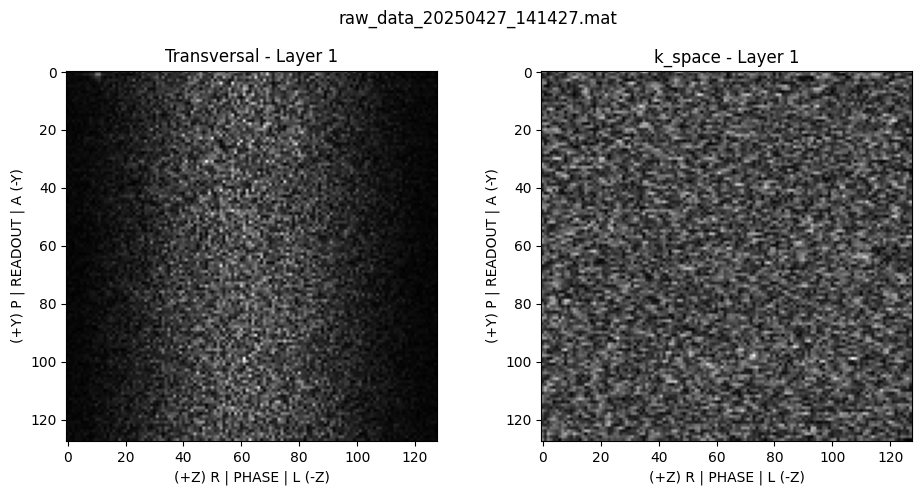

[{'widget': 'image',
  'data': array([[[1.10569368, 2.18986299, 5.30760426, ..., 2.14206105,
           4.12712474, 0.66931121],
          [4.90164197, 4.90502293, 3.38551831, ..., 2.43494432,
           5.94194319, 1.96429573],
          [3.75976792, 4.43890788, 3.65978188, ..., 1.71108228,
           2.20816728, 1.33389318],
          ...,
          [1.894605  , 8.38605105, 1.77356923, ..., 2.88000087,
           4.3769763 , 2.49722788],
          [6.54079326, 2.36115192, 1.49459584, ..., 1.81825195,
           3.92928569, 2.38999121],
          [5.10650787, 3.2905586 , 2.30188161, ..., 3.49767401,
           5.26225864, 4.04290553]]]),
  'xLabel': '(+Z) R | PHASE | L (-Z)',
  'yLabel': '(+Y) P | READOUT | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.92325345, -1.92739983, -1.98431683, ..., -1.95758454,
           -1.94526803, -1.93218887],
          [-1.98242815, -1.95975964, -1.99125359, ..., -1.96790242,
           -1.96805

In [ ]:

seq = SPRITER2dSEQ(nScans=1, larmorFreq=10.53366, rfExFA=90, repetitionTime=10,
                 rfExTime=400, echoTime=1, nPoints=1, riseTime=0.5,
                 SpoilingTimeAfterRising=0.5, fov=[150, 150], bandwidth=106.66666666666667,
                 SamplingPoints=[128, 128], shimming=[0.0013, 0.0013, 0.0005], txChannel=0, rxChannel=0,
                 axesOrientation=[1, 2, 0])

print(f"seq total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data']).max()}')
seq.sequenceAnalysis(mode='Standalone')


seq total time: 2.0 min 43.84 seconds
Acquisition bandwidth fixed to: 106.667 kHz
dwell time: 9.375 us, readout time: 9.375e-06 s
read 5 definitions, 98305 blocks, 137 shapes, 1 adc events, 1 rf events, 770 gradient shapes
Center frequecy set: 10.53366 MHz
Scan running...
Acquired points = 16384, Expected points = 16384
Scan ready!
------------ max abs value: 0.251916082001488
Moved: raw_data_20250427_142319 to experiments/acquisitions/2025.04.27


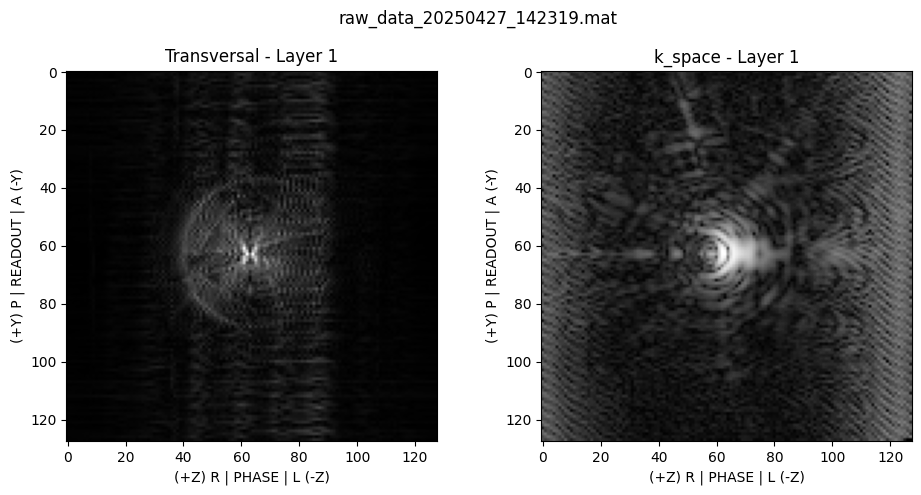

[{'widget': 'image',
  'data': array([[[0.95471359, 0.90460197, 0.81521698, ..., 0.98927867,
           1.11179767, 1.08469607],
          [0.39829053, 0.47122069, 0.56250116, ..., 0.46118407,
           0.51270395, 0.57463733],
          [0.26121115, 0.33400005, 0.64114906, ..., 0.55985739,
           0.57346394, 0.37931595],
          ...,
          [1.5006925 , 1.53174628, 1.40041519, ..., 1.38049219,
           1.4521205 , 1.46468031],
          [1.00377532, 1.14259063, 1.33780151, ..., 1.45003939,
           1.40791399, 1.08844394],
          [0.89776454, 0.88411649, 1.0815406 , ..., 0.74006651,
           0.64991962, 0.82120215]]]),
  'xLabel': '(+Z) R | PHASE | L (-Z)',
  'yLabel': '(+Y) P | READOUT | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.88370401, -1.58836481, -1.51956981, ..., -1.47295061,
           -1.48339868, -1.42367572],
          [-1.38299801, -1.69490882, -1.5525804 , ..., -1.32589558,
           -1.53103

In [16]:

seq = SPRITER2dSEQ(nScans=1, larmorFreq=10.53366, rfExFA=90, repetitionTime=10,
                 rfExTime=400, echoTime=1, nPoints=1, riseTime=0.5,
                 SpoilingTimeAfterRising=0.5, fov=[150, 150], bandwidth=106.66666666666667,
                 SamplingPoints=[128, 128], shimming=[0.0013, 0.0013, 0.0005], txChannel=0, rxChannel=0,
                 axesOrientation=[1, 2, 0])

print(f"seq total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data']).max()}')
seq.sequenceAnalysis(mode='Standalone')


seq total time: 2.0 min 43.84 seconds
Acquisition bandwidth fixed to: 106.667 kHz
dwell time: 9.375 us, readout time: 9.375e-06 s
read 5 definitions, 98305 blocks, 137 shapes, 1 adc events, 1 rf events, 770 gradient shapes
Center frequecy set: 10.53366 MHz
Scan running...


/home/lks/MaSeq_pack/marcos_client/experiment.py:229: UserWarning: Unknown marga experiment dictionary key: lo0_freq_offset
  warnings.warn("Unknown marga experiment dictionary key: " + key)
/home/lks/MaSeq_pack/marcos_client/experiment.py:229: UserWarning: Unknown marga experiment dictionary key: lo1_freq_offset
  warnings.warn("Unknown marga experiment dictionary key: " + key)
/home/lks/MaSeq_pack/marcos_client/experiment.py:229: UserWarning: Unknown marga experiment dictionary key: lo0_rst
  warnings.warn("Unknown marga experiment dictionary key: " + key)
/home/lks/MaSeq_pack/marcos_client/experiment.py:229: UserWarning: Unknown marga experiment dictionary key: lo1_rst
  warnings.warn("Unknown marga experiment dictionary key: " + key)
/home/lks/MaSeq_pack/marcos_client/marcompile.py:245: MarGradWarning: Gradient updates are too frequent for selected SPI divider. Missed samples are likely!
  warnings.warn("Gradient updates are too frequent for selected SPI divider. Missed samples are

Acquired points = 16384, Expected points = 16384
Scan ready!
------------ max abs value: 2.472655345398076
Moved: raw_data_20250427_143511 to experiments/acquisitions/2025.04.27


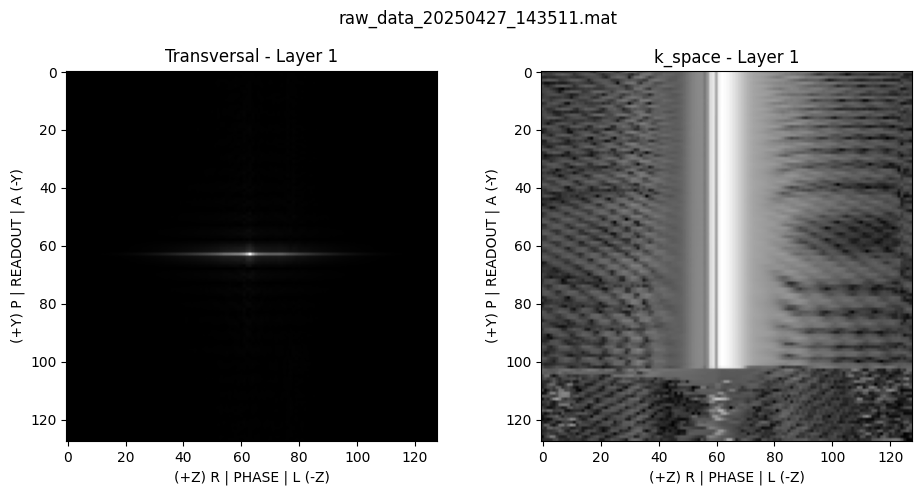

[{'widget': 'image',
  'data': array([[[0.02996699, 0.01343877, 0.02304667, ..., 0.01134612,
           0.04258647, 0.02625747],
          [0.0266316 , 0.01412286, 0.01266667, ..., 0.00974228,
           0.02042074, 0.00510447],
          [0.00891261, 0.02139758, 0.0330218 , ..., 0.01232189,
           0.04461895, 0.03633566],
          ...,
          [0.03631709, 0.04227142, 0.03707436, ..., 0.01427825,
           0.04062118, 0.02031224],
          [0.02689065, 0.00467944, 0.01501983, ..., 0.01737987,
           0.04133931, 0.00501587],
          [0.02689663, 0.01692999, 0.00119994, ..., 0.03178709,
           0.03536806, 0.01024116]]]),
  'xLabel': '(+Z) R | PHASE | L (-Z)',
  'yLabel': '(+Y) P | READOUT | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.60444408, -1.63840425, -1.51817524, ..., -1.18979827,
           -1.20099556, -1.19830292],
          [-1.25774408, -1.386091  , -1.4324045 , ..., -1.67710898,
           -1.72280

In [17]:

seq = SPRITER2dSEQ(nScans=1, larmorFreq=10.53366, rfExFA=90, repetitionTime=10,
                 rfExTime=400, echoTime=0.3, nPoints=1, riseTime=0.5,
                 SpoilingTimeAfterRising=0.5, fov=[150, 150], bandwidth=106.66666666666667,
                 SamplingPoints=[128, 128], shimming=[0.0013, 0.0013, 0.0005], txChannel=0, rxChannel=0,
                 axesOrientation=[1, 2, 0])

print(f"seq total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data']).max()}')
seq.sequenceAnalysis(mode='Standalone')


seq total time: 2.0 min 43.84 seconds
Acquisition bandwidth fixed to: 106.667 kHz
dwell time: 9.375 us, readout time: 9.375e-06 s
read 5 definitions, 98305 blocks, 137 shapes, 1 adc events, 1 rf events, 770 gradient shapes
Center frequecy set: 10.53417 MHz
Scan running...


/home/lks/MaSeq_pack/marcos_client/server_comms.py:93: RuntimeWarning: SERVER ERROR: memory buffer underrun around byte address 0x4c0000
  warnings.warn("SERVER ERROR: " + k, RuntimeWarning)


Repeating batch...
Acquired points = 16384, Expected points = 16384
Scan ready!
------------ max abs value: 2.3530124286001626
Moved: raw_data_20250427_144820 to experiments/acquisitions/2025.04.27


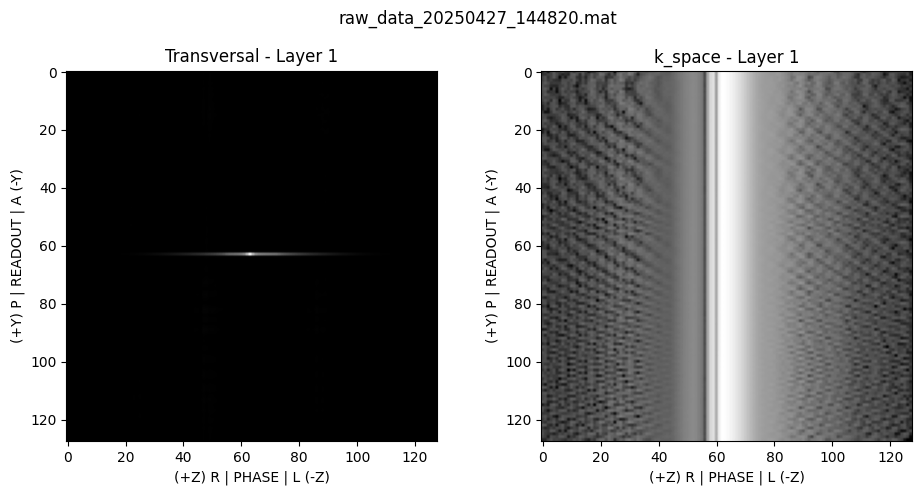

[{'widget': 'image',
  'data': array([[[0.02006388, 0.01937749, 0.01890565, ..., 0.0196321 ,
           0.02007823, 0.01925649],
          [0.00803797, 0.00643844, 0.00670503, ..., 0.00700266,
           0.00982091, 0.01017671],
          [0.0146672 , 0.01427635, 0.0115505 , ..., 0.01290286,
           0.012844  , 0.01372057],
          ...,
          [0.00361913, 0.0053082 , 0.0058063 , ..., 0.00421319,
           0.00529167, 0.00458512],
          [0.01367379, 0.01133713, 0.01176633, ..., 0.01242596,
           0.01313773, 0.01389249],
          [0.00731849, 0.00775128, 0.00680194, ..., 0.00606452,
           0.0079248 , 0.00702635]]]),
  'xLabel': '(+Z) R | PHASE | L (-Z)',
  'yLabel': '(+Y) P | READOUT | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.67428547, -1.3903091 , -1.90231933, ..., -1.41098199,
           -1.41366615, -1.72178542],
          [-1.54607427, -1.52749455, -1.39639625, ..., -1.55331985,
           -1.33913

In [18]:

seq = SPRITER2dSEQ(nScans=1, larmorFreq=10.53417, rfExFA=90, repetitionTime=10,
                 rfExTime=400, echoTime=0.3, nPoints=1, riseTime=0.5,
                 SpoilingTimeAfterRising=0.5, fov=[180, 180], bandwidth=106.66666666666667,
                 SamplingPoints=[128, 128], shimming=[0.0013, 0.0013, 0.0005], txChannel=0, rxChannel=0,
                 axesOrientation=[1, 2, 0])

print(f"seq total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data']).max()}')
seq.sequenceAnalysis(mode='Standalone')


seq total time: 0.0 min 40.96 seconds
Acquisition bandwidth fixed to: 106.667 kHz
dwell time: 9.375 us, readout time: 9.375e-06 s
read 5 definitions, 24577 blocks, 73 shapes, 1 adc events, 1 rf events, 386 gradient shapes
Center frequecy set: 10.534279999999999 MHz
Scan running...
Acquired points = 4096, Expected points = 4096
Scan ready!
------------ max abs value: 1.53513224297621
Moved: raw_data_20250427_150148 to experiments/acquisitions/2025.04.27


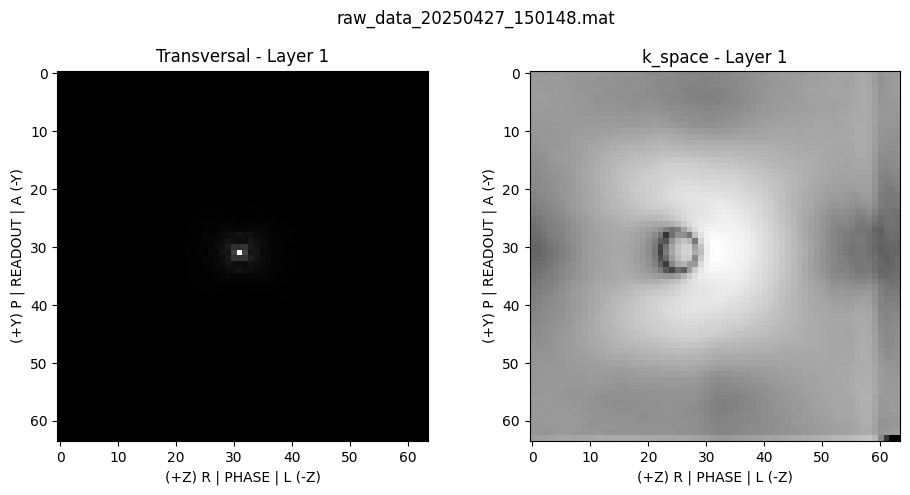

[{'widget': 'image',
  'data': array([[[0.01010335, 0.01153425, 0.01044151, ..., 0.01237037,
           0.01175807, 0.01060457],
          [0.00882764, 0.01200791, 0.01031171, ..., 0.01189447,
           0.01187309, 0.01228365],
          [0.01085699, 0.00918756, 0.01058757, ..., 0.01140795,
           0.00866078, 0.00797349],
          ...,
          [0.01324496, 0.01195319, 0.01129024, ..., 0.01064709,
           0.01112541, 0.01489642],
          [0.01007326, 0.0103429 , 0.00997198, ..., 0.01140077,
           0.00975684, 0.01043819],
          [0.00982482, 0.00831609, 0.00972681, ..., 0.01165144,
           0.00974425, 0.00850467]]]),
  'xLabel': '(+Z) R | PHASE | L (-Z)',
  'yLabel': '(+Y) P | READOUT | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-0.6956289 , -0.70444411, -0.70791087, ..., -0.69617004,
           -0.66964604, -0.66955778],
          [-0.68032952, -0.67474279, -0.67083113, ..., -0.70416996,
           -0.68007

In [19]:

seq = SPRITER2dSEQ(nScans=1, larmorFreq=10.53428, rfExFA=90, repetitionTime=10,
                 rfExTime=400, echoTime=0.3, nPoints=1, riseTime=0.5,
                 SpoilingTimeAfterRising=0.5, fov=[300, 300], bandwidth=106.66666666666667,
                 SamplingPoints=[64, 64], shimming=[0.0013, 0.0013, 0.0005], txChannel=0, rxChannel=0,
                 axesOrientation=[1, 2, 0])

print(f"seq total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data']).max()}')
seq.sequenceAnalysis(mode='Standalone')


seq total time: 2.0 min 43.84 seconds
Acquisition bandwidth fixed to: 106.667 kHz
dwell time: 9.375 us, readout time: 9.375e-06 s
read 5 definitions, 98305 blocks, 137 shapes, 1 adc events, 1 rf events, 770 gradient shapes
Center frequecy set: 10.534279999999999 MHz
Scan running...
Acquired points = 16384, Expected points = 16384
Scan ready!
------------ max abs value: 2.0440959330918504
Moved: raw_data_20250427_150935 to experiments/acquisitions/2025.04.27


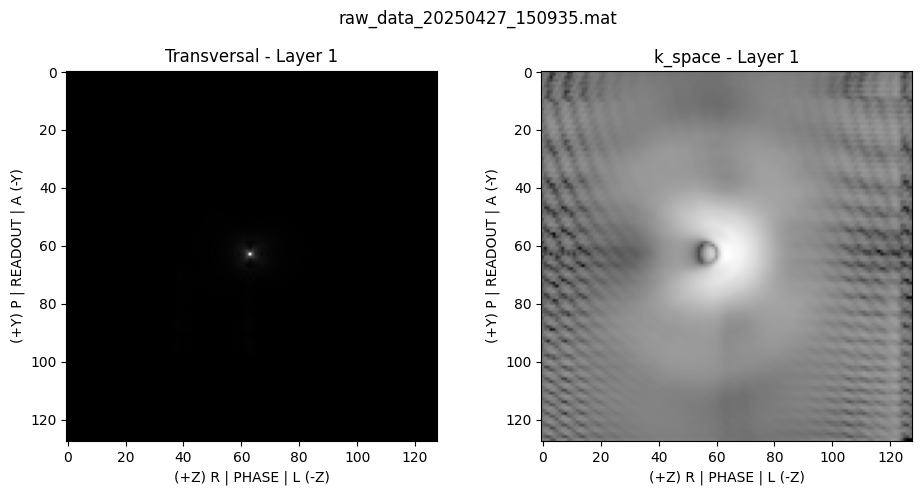

[{'widget': 'image',
  'data': array([[[0.00489204, 0.02020547, 0.02431913, ..., 0.04223302,
           0.03035946, 0.01686931],
          [0.00300822, 0.01175879, 0.0161141 , ..., 0.02259243,
           0.01247405, 0.00642938],
          [0.00635013, 0.00847388, 0.01086008, ..., 0.01429068,
           0.00834027, 0.00542821],
          ...,
          [0.00633928, 0.03403959, 0.04108876, ..., 0.09175503,
           0.06135635, 0.0307668 ],
          [0.00302442, 0.03337586, 0.04162609, ..., 0.09036448,
           0.06514002, 0.03709193],
          [0.00351365, 0.02638165, 0.033562  , ..., 0.0661193 ,
           0.04973455, 0.02982838]]]),
  'xLabel': '(+Z) R | PHASE | L (-Z)',
  'yLabel': '(+Y) P | READOUT | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-0.84674038, -1.01272471, -1.0472666 , ..., -1.5282716 ,
           -1.57377817, -1.0318882 ],
          [-1.01481406, -0.92922184, -1.00751149, ..., -1.33268295,
           -1.13569

In [20]:

seq = SPRITER2dSEQ(nScans=1, larmorFreq=10.53428, rfExFA=90, repetitionTime=10,
                 rfExTime=400, echoTime=0.3, nPoints=1, riseTime=0.5,
                 SpoilingTimeAfterRising=0.5, fov=[300, 300], bandwidth=106.66666666666667,
                 SamplingPoints=[128, 128], shimming=[0.0013, 0.0013, 0.0005], txChannel=0, rxChannel=0,
                 axesOrientation=[1, 2, 0])

print(f"seq total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data']).max()}')
seq.sequenceAnalysis(mode='Standalone')


seq total time: 2.0 min 43.84 seconds
Acquisition bandwidth fixed to: 106.667 kHz
dwell time: 9.375 us, readout time: 9.375e-06 s
read 5 definitions, 98305 blocks, 137 shapes, 1 adc events, 1 rf events, 770 gradient shapes
Center frequecy set: 10.534569999999999 MHz
Scan running...
Acquired points = 16384, Expected points = 16384
Scan ready!
------------ max abs value: 0.8638634327107234
Moved: raw_data_20250427_151936 to experiments/acquisitions/2025.04.27


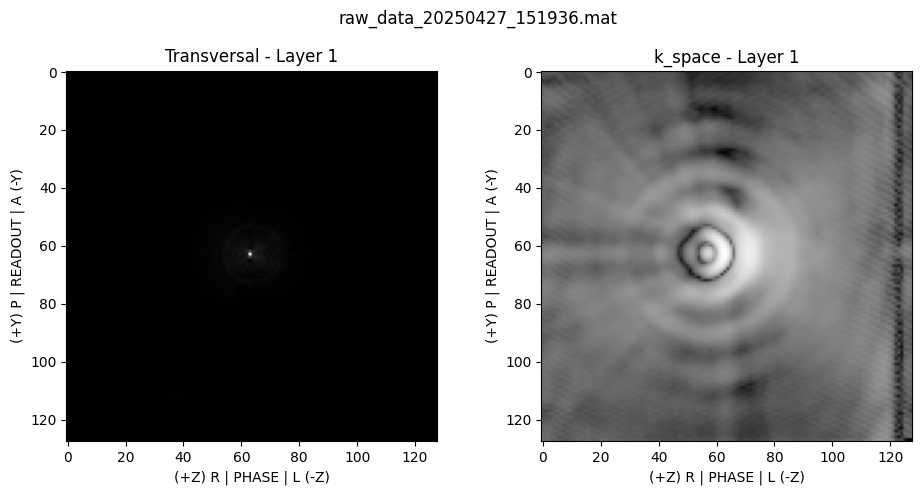

[{'widget': 'image',
  'data': array([[[0.00516682, 0.00775379, 0.00602998, ..., 0.00662975,
           0.00789375, 0.00440667],
          [0.00214696, 0.00442153, 0.00727046, ..., 0.00662581,
           0.00462559, 0.00253292],
          [0.00308161, 0.00783631, 0.00782026, ..., 0.00539092,
           0.00588182, 0.00727501],
          ...,
          [0.00458143, 0.00528256, 0.00905478, ..., 0.00217575,
           0.00186588, 0.00439103],
          [0.00073172, 0.00222235, 0.00306805, ..., 0.00174045,
           0.00311046, 0.00236974],
          [0.00203829, 0.00370426, 0.00461758, ..., 0.00513421,
           0.00410681, 0.00052825]]]),
  'xLabel': '(+Z) R | PHASE | L (-Z)',
  'yLabel': '(+Y) P | READOUT | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.31166593, -1.29792427, -1.3019905 , ..., -1.35417194,
           -1.33303099, -1.26218037],
          [-1.30085041, -1.36154749, -1.32515518, ..., -1.27674858,
           -1.41327

In [22]:

seq = SPRITER2dSEQ(nScans=1, larmorFreq=10.53457, rfExFA=90, repetitionTime=10,
                 rfExTime=400, echoTime=0.5, nPoints=1, riseTime=0.5,
                 SpoilingTimeAfterRising=0.5, fov=[300, 300], bandwidth=106.66666666666667,
                 SamplingPoints=[128, 128], shimming=[0.0013, 0.0013, 0.0005], txChannel=0, rxChannel=0,
                 axesOrientation=[1, 2, 0])

print(f"seq total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data']).max()}')
seq.sequenceAnalysis(mode='Standalone')


seq total time: 0.0 min 40.96 seconds
Acquisition bandwidth fixed to: 106.667 kHz
dwell time: 9.375 us, readout time: 9.375e-06 s
read 5 definitions, 24577 blocks, 73 shapes, 1 adc events, 1 rf events, 386 gradient shapes
Center frequecy set: 10.534569999999999 MHz
Scan running...
Acquired points = 4096, Expected points = 4096
Scan ready!
------------ max abs value: 0.22476612670469986
Moved: raw_data_20250427_152703 to experiments/acquisitions/2025.04.27


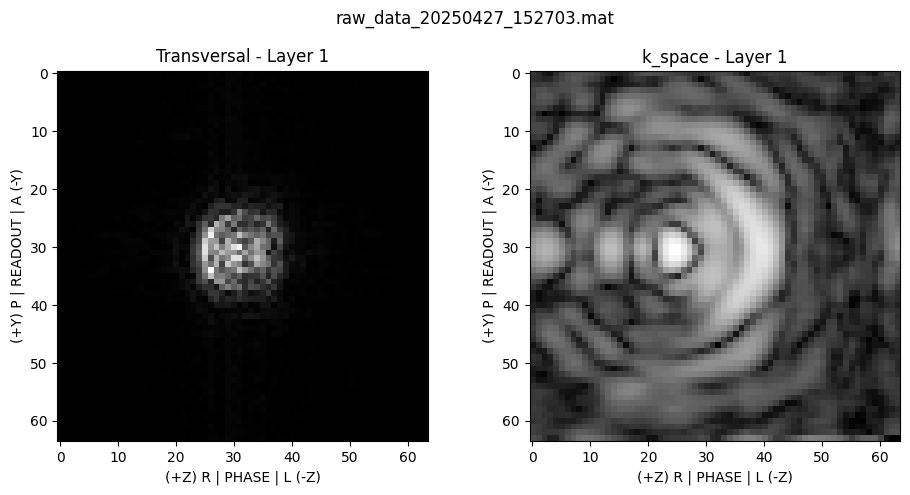

[{'widget': 'image',
  'data': array([[[0.03263221, 0.07121759, 0.05990132, ..., 0.07673109,
           0.0045385 , 0.0871307 ],
          [0.09363267, 0.10078419, 0.11503243, ..., 0.15069744,
           0.0585796 , 0.08692335],
          [0.07062573, 0.10543116, 0.07148225, ..., 0.12968627,
           0.10207232, 0.10413855],
          ...,
          [0.06651014, 0.07783316, 0.09445085, ..., 0.07377709,
           0.03296992, 0.10912064],
          [0.01484949, 0.01430144, 0.02461747, ..., 0.06406913,
           0.06421746, 0.05310579],
          [0.11054936, 0.09069072, 0.18857486, ..., 0.10070014,
           0.13921166, 0.13279161]]]),
  'xLabel': '(+Z) R | PHASE | L (-Z)',
  'yLabel': '(+Y) P | READOUT | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.70709333, -1.76852468, -1.86548308, ..., -1.66049796,
           -1.68113714, -1.73088629],
          [-1.7397412 , -1.75542576, -1.80560194, ..., -1.73644777,
           -1.75193

In [23]:

seq = SPRITER2dSEQ(nScans=1, larmorFreq=10.53457, rfExFA=90, repetitionTime=10,
                 rfExTime=400, echoTime=1, nPoints=1, riseTime=0.5,
                 SpoilingTimeAfterRising=0.5, fov=[300, 300], bandwidth=106.66666666666667,
                 SamplingPoints=[64, 64], shimming=[0.0013, 0.0013, 0.0005], txChannel=0, rxChannel=0,
                 axesOrientation=[1, 2, 0])

print(f"seq total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data']).max()}')
seq.sequenceAnalysis(mode='Standalone')


seq total time: 2.0 min 43.84 seconds
Acquisition bandwidth fixed to: 106.667 kHz
dwell time: 9.375 us, readout time: 9.375e-06 s
read 5 definitions, 98305 blocks, 137 shapes, 1 adc events, 1 rf events, 770 gradient shapes
Center frequecy set: 10.534569999999999 MHz
Scan running...
Acquired points = 16384, Expected points = 16384
Scan ready!
------------ max abs value: 0.2537325204615099
Moved: raw_data_20250427_153117 to experiments/acquisitions/2025.04.27


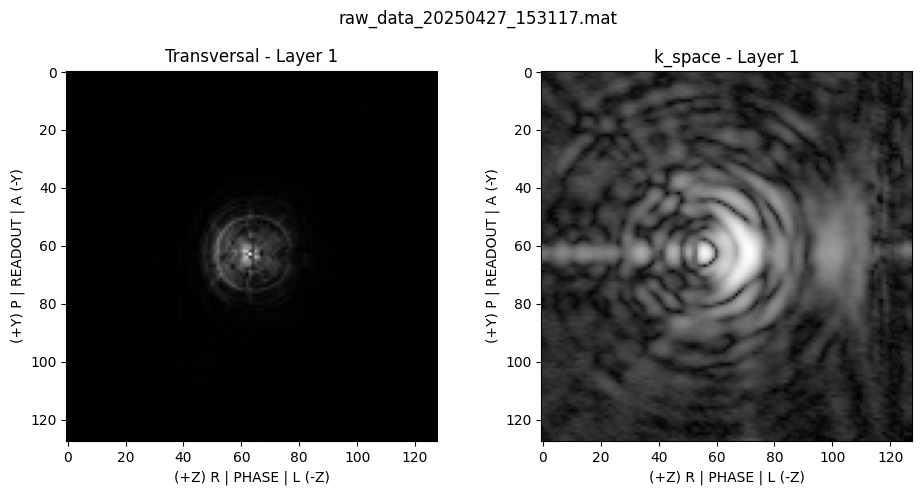

[{'widget': 'image',
  'data': array([[[0.04593655, 0.03970882, 0.00219612, ..., 0.04972466,
           0.01177673, 0.02056995],
          [0.02553151, 0.06922922, 0.04331343, ..., 0.02531911,
           0.02178156, 0.05128611],
          [0.07635476, 0.00909164, 0.01768684, ..., 0.07592429,
           0.05391588, 0.03501466],
          ...,
          [0.02162386, 0.02579872, 0.07656747, ..., 0.01351705,
           0.00722785, 0.05286122],
          [0.00530097, 0.02925392, 0.03007264, ..., 0.04884256,
           0.0289884 , 0.05206657],
          [0.03279378, 0.0274389 , 0.02256198, ..., 0.03914944,
           0.01024094, 0.0436232 ]]]),
  'xLabel': '(+Z) R | PHASE | L (-Z)',
  'yLabel': '(+Y) P | READOUT | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.83021578, -1.87464238, -1.76498824, ..., -1.77456047,
           -1.77735743, -1.79619484],
          [-1.88780746, -1.89030326, -1.85667113, ..., -1.7558645 ,
           -1.71746

In [24]:

seq = SPRITER2dSEQ(nScans=1, larmorFreq=10.53457, rfExFA=90, repetitionTime=10,
                 rfExTime=400, echoTime=1, nPoints=1, riseTime=0.5,
                 SpoilingTimeAfterRising=0.5, fov=[300, 300], bandwidth=106.66666666666667,
                 SamplingPoints=[128, 128], shimming=[0.0013, 0.0013, 0.0005], txChannel=0, rxChannel=0,
                 axesOrientation=[1, 2, 0])

print(f"seq total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data']).max()}')
seq.sequenceAnalysis(mode='Standalone')


seq total time: 2.0 min 43.84 seconds
Acquisition bandwidth fixed to: 106.667 kHz
dwell time: 9.375 us, readout time: 9.375e-06 s
read 5 definitions, 98305 blocks, 137 shapes, 1 adc events, 1 rf events, 770 gradient shapes
Center frequecy set: 10.53502 MHz
Scan running...
Acquired points = 16384, Expected points = 16384
Scan ready!
------------ max abs value: 0.29892541940642114
Moved: raw_data_20250427_153818 to experiments/acquisitions/2025.04.27


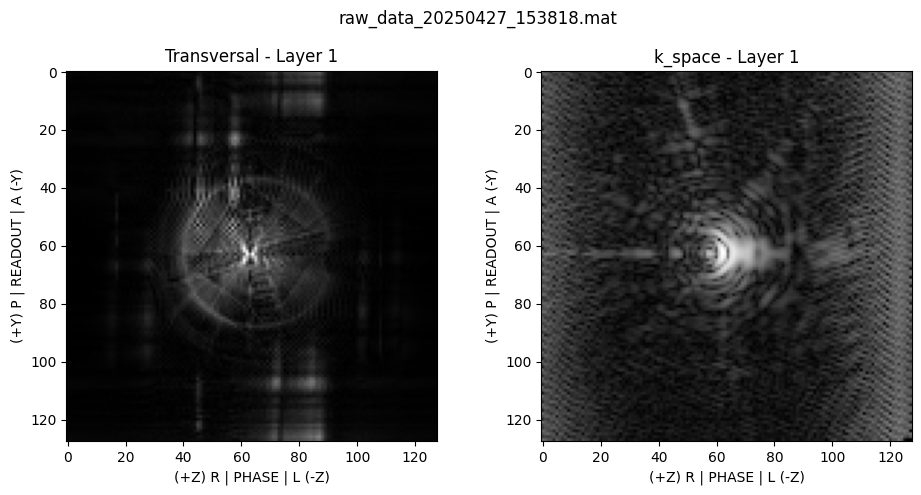

[{'widget': 'image',
  'data': array([[[2.57431554, 2.54746465, 2.31710258, ..., 1.79559608,
           1.90331545, 2.18876076],
          [2.15057356, 2.22843054, 2.19270771, ..., 1.74308745,
           1.80298117, 2.05620195],
          [1.5191917 , 1.12738444, 0.99462449, ..., 1.48934591,
           1.71548075, 1.64418487],
          ...,
          [1.99705899, 2.14225075, 2.2392361 , ..., 2.25995176,
           2.29503309, 2.03784947],
          [2.35791152, 2.69309701, 2.98658313, ..., 2.55611867,
           2.32191701, 2.32018929],
          [2.77885986, 2.96148431, 2.86283596, ..., 2.03777466,
           2.0982228 , 2.35627468]]]),
  'xLabel': '(+Z) R | PHASE | L (-Z)',
  'yLabel': '(+Y) P | READOUT | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.42562085, -1.65938086, -1.57777851, ..., -1.37286571,
           -1.62757219, -1.55402645],
          [-1.49007963, -1.41023834, -1.52169308, ..., -1.45305108,
           -1.38305

In [25]:

seq = SPRITER2dSEQ(nScans=1, larmorFreq=10.53502, rfExFA=90, repetitionTime=10,
                 rfExTime=400, echoTime=1, nPoints=1, riseTime=0.5,
                 SpoilingTimeAfterRising=0.5, fov=[150, 150], bandwidth=106.66666666666667,
                 SamplingPoints=[128, 128], shimming=[0.0015, 0.0019, 0.0005], txChannel=0, rxChannel=0,
                 axesOrientation=[1, 2, 0])

print(f"seq total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data']).max()}')
seq.sequenceAnalysis(mode='Standalone')


seq total time: 0.0 min 10.24 seconds
Acquisition bandwidth fixed to: 106.667 kHz
dwell time: 9.375 us, readout time: 9.375e-06 s
read 5 definitions, 6145 blocks, 41 shapes, 1 adc events, 1 rf events, 194 gradient shapes
Center frequecy set: 10.53516 MHz
Scan running...


/home/lks/MaSeq_pack/marcos_client/experiment.py:229: UserWarning: Unknown marga experiment dictionary key: lo0_freq_offset
  warnings.warn("Unknown marga experiment dictionary key: " + key)
/home/lks/MaSeq_pack/marcos_client/experiment.py:229: UserWarning: Unknown marga experiment dictionary key: lo1_freq_offset
  warnings.warn("Unknown marga experiment dictionary key: " + key)
/home/lks/MaSeq_pack/marcos_client/experiment.py:229: UserWarning: Unknown marga experiment dictionary key: lo0_rst
  warnings.warn("Unknown marga experiment dictionary key: " + key)
/home/lks/MaSeq_pack/marcos_client/experiment.py:229: UserWarning: Unknown marga experiment dictionary key: lo1_rst
  warnings.warn("Unknown marga experiment dictionary key: " + key)
/home/lks/MaSeq_pack/marcos_client/marcompile.py:245: MarGradWarning: Gradient updates are too frequent for selected SPI divider. Missed samples are likely!
  warnings.warn("Gradient updates are too frequent for selected SPI divider. Missed samples are

Acquired points = 1024, Expected points = 1024
Scan ready!
------------ max abs value: 0.3559050052198519
Moved: raw_data_20250427_154347 to experiments/acquisitions/2025.04.27


/home/lks/MaSeq_pack/marcos_client/server_comms.py:86: MarServerWarning: ocra1 data was lost (overwritten before being sent)
  warnings.warn(k, MarServerWarning)


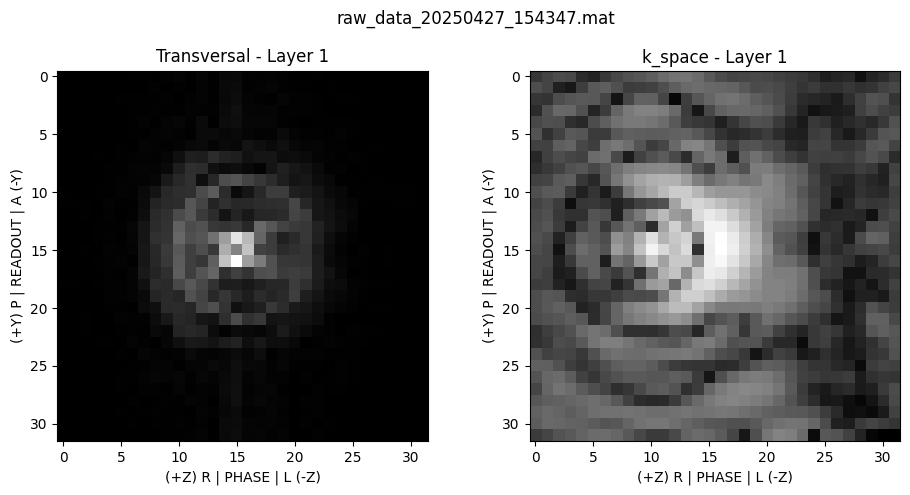

[{'widget': 'image',
  'data': array([[[0.08765906, 0.1445161 , 0.0989339 , ..., 0.13236796,
           0.11926046, 0.11974274],
          [0.05397901, 0.05112342, 0.14713905, ..., 0.15095881,
           0.05927219, 0.11568145],
          [0.14880679, 0.20579023, 0.18016759, ..., 0.16154708,
           0.16804996, 0.16498015],
          ...,
          [0.20530374, 0.34745839, 0.18340121, ..., 0.19972107,
           0.21053211, 0.22416633],
          [0.15303552, 0.24641104, 0.21739628, ..., 0.0566881 ,
           0.19469992, 0.15631794],
          [0.0871029 , 0.15470885, 0.05898862, ..., 0.09973418,
           0.09354354, 0.09185511]]]),
  'xLabel': '(+Z) R | PHASE | L (-Z)',
  'yLabel': '(+Y) P | READOUT | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.66867218, -1.58648893, -1.53440232, ..., -1.77492269,
           -1.73374732, -1.63368445],
          [-1.52244128, -1.58230965, -1.79847478, ..., -1.67552457,
           -1.59882

In [26]:

seq = SPRITER2dSEQ(nScans=1, larmorFreq=10.53516, rfExFA=90, repetitionTime=10,
                 rfExTime=400, echoTime=0.7, nPoints=1, riseTime=0.5,
                 SpoilingTimeAfterRising=0.5, fov=[150, 150], bandwidth=106.66666666666667,
                 SamplingPoints=[32, 32], shimming=[0.0015, 0.0019, 0.0005], txChannel=0, rxChannel=0,
                 axesOrientation=[1, 2, 0])

print(f"seq total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data']).max()}')
seq.sequenceAnalysis(mode='Standalone')


seq total time: 2.0 min 43.84 seconds
Acquisition bandwidth fixed to: 106.667 kHz
dwell time: 9.375 us, readout time: 9.375e-06 s
read 5 definitions, 98305 blocks, 137 shapes, 1 adc events, 1 rf events, 770 gradient shapes
Center frequecy set: 10.53524 MHz
Scan running...
Acquired points = 16384, Expected points = 16384
Scan ready!
------------ max abs value: 0.8175304319840775
Moved: raw_data_20250427_155359 to experiments/acquisitions/2025.04.27


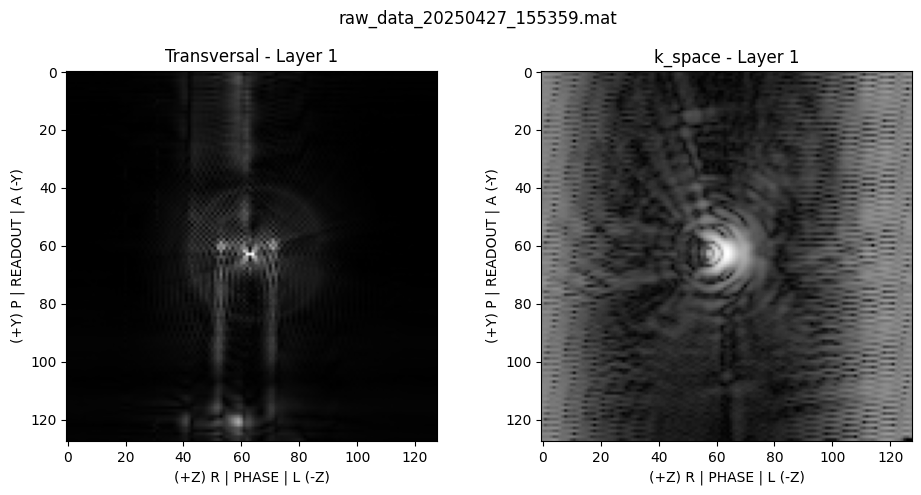

[{'widget': 'image',
  'data': array([[[0.60809071, 0.60659304, 0.59654385, ..., 0.67304789,
           0.67156484, 0.65637619],
          [0.35979503, 0.36103363, 0.36421776, ..., 0.3385893 ,
           0.34066848, 0.36808545],
          [0.64637028, 0.650984  , 0.67438255, ..., 0.62646726,
           0.65385979, 0.65761842],
          ...,
          [1.05685121, 1.04362657, 1.07686086, ..., 1.17486731,
           1.12165903, 1.08344751],
          [1.3395412 , 1.32000604, 1.2985246 , ..., 1.34663601,
           1.29407841, 1.30426369],
          [1.01243779, 1.0317938 , 1.07144576, ..., 0.97070074,
           0.96866908, 1.01771143]]]),
  'xLabel': '(+Z) R | PHASE | L (-Z)',
  'yLabel': '(+Y) P | READOUT | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-0.98653564, -1.22821608, -1.27457152, ..., -1.11888468,
           -1.14158841, -1.08613106],
          [-0.97545838, -0.92688147, -0.95510511, ..., -0.92048208,
           -0.87293

In [28]:

seq = SPRITER2dSEQ(nScans=1, larmorFreq=10.53524, rfExFA=90, repetitionTime=10,
                 rfExTime=400, echoTime=0.7, nPoints=1, riseTime=0.5,
                 SpoilingTimeAfterRising=0.5, fov=[150, 150], bandwidth=106.66666666666667,
                 SamplingPoints=[128, 128], shimming=[0.0015, 0.0019, 0.0005], txChannel=0, rxChannel=0,
                 axesOrientation=[1, 2, 0])

print(f"seq total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data']).max()}')
seq.sequenceAnalysis(mode='Standalone')


seq total time: 2.0 min 43.84 seconds
Acquisition bandwidth fixed to: 106.667 kHz
dwell time: 9.375 us, readout time: 9.375e-06 s
read 5 definitions, 98305 blocks, 137 shapes, 1 adc events, 1 rf events, 770 gradient shapes
Center frequecy set: 10.53537 MHz
Scan running...


/home/lks/MaSeq_pack/marcos_client/experiment.py:229: UserWarning: Unknown marga experiment dictionary key: lo0_freq_offset
  warnings.warn("Unknown marga experiment dictionary key: " + key)
/home/lks/MaSeq_pack/marcos_client/experiment.py:229: UserWarning: Unknown marga experiment dictionary key: lo1_freq_offset
  warnings.warn("Unknown marga experiment dictionary key: " + key)
/home/lks/MaSeq_pack/marcos_client/experiment.py:229: UserWarning: Unknown marga experiment dictionary key: lo0_rst
  warnings.warn("Unknown marga experiment dictionary key: " + key)
/home/lks/MaSeq_pack/marcos_client/experiment.py:229: UserWarning: Unknown marga experiment dictionary key: lo1_rst
  warnings.warn("Unknown marga experiment dictionary key: " + key)
/home/lks/MaSeq_pack/marcos_client/marcompile.py:245: MarGradWarning: Gradient updates are too frequent for selected SPI divider. Missed samples are likely!
  warnings.warn("Gradient updates are too frequent for selected SPI divider. Missed samples are

Acquired points = 16384, Expected points = 16384
Scan ready!
------------ max abs value: 0.07962455990819868
Moved: raw_data_20250427_160008 to experiments/acquisitions/2025.04.27


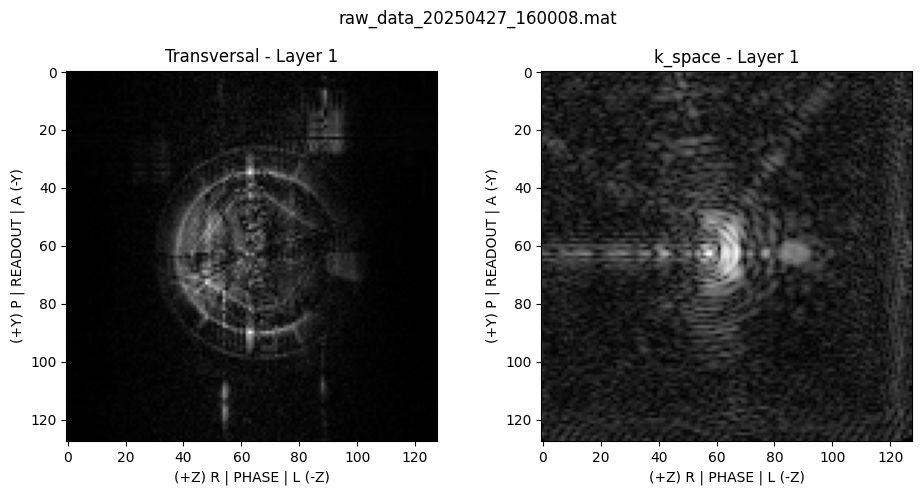

[{'widget': 'image',
  'data': array([[[0.56947828, 0.79832764, 0.7144724 , ..., 0.33425233,
           0.56722081, 0.59747765],
          [1.06285535, 0.81326328, 0.9520901 , ..., 0.48050832,
           0.61138285, 1.14566587],
          [0.12773622, 0.95366815, 0.1763143 , ..., 0.83737884,
           0.21173476, 0.319832  ],
          ...,
          [0.25097328, 0.56166532, 0.47824693, ..., 0.14125524,
           0.42944563, 0.09264135],
          [0.06557322, 0.24594232, 0.25671142, ..., 0.50259003,
           0.09165335, 0.17100172],
          [0.05255487, 0.54164794, 0.11998307, ..., 0.08422451,
           0.47150595, 0.23013244]]]),
  'xLabel': '(+Z) R | PHASE | L (-Z)',
  'yLabel': '(+Y) P | READOUT | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.92732633, -1.92963069, -1.88967354, ..., -1.89202634,
           -1.91416287, -1.93487928],
          [-1.88541564, -1.847942  , -1.84359917, ..., -1.92245577,
           -1.84200

In [29]:

seq = SPRITER2dSEQ(nScans=1, larmorFreq=10.53537, rfExFA=90, repetitionTime=10,
                 rfExTime=400, echoTime=1.5, nPoints=1, riseTime=0.5,
                 SpoilingTimeAfterRising=0.5, fov=[150, 150], bandwidth=106.66666666666667,
                 SamplingPoints=[128, 128], shimming=[0.0015, 0.0019, 0.0005], txChannel=0, rxChannel=0,
                 axesOrientation=[1, 2, 0])

print(f"seq total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data']).max()}')
seq.sequenceAnalysis(mode='Standalone')


seq total time: 8.0 min 11.519999999999982 seconds
Acquisition bandwidth fixed to: 106.667 kHz
dwell time: 9.375 us, readout time: 9.375e-06 s
read 5 definitions, 98305 blocks, 137 shapes, 1 adc events, 1 rf events, 770 gradient shapes
Center frequecy set: 10.53584 MHz
Scan 1 running...


/home/lks/MaSeq_pack/marcos_client/server_comms.py:93: RuntimeWarning: SERVER ERROR: memory buffer underrun around byte address 0x580000
  warnings.warn("SERVER ERROR: " + k, RuntimeWarning)


Repeating batch...
Acquired points = 16384, Expected points = 16384
Scan 1 ready!
Scan 2 running...
Acquired points = 16384, Expected points = 16384
Scan 2 ready!
Scan 3 running...
Acquired points = 16384, Expected points = 16384
Scan 3 ready!
------------ max abs value: 0.3081895642729936
Moved: raw_data_20250427_165641 to experiments/acquisitions/2025.04.27


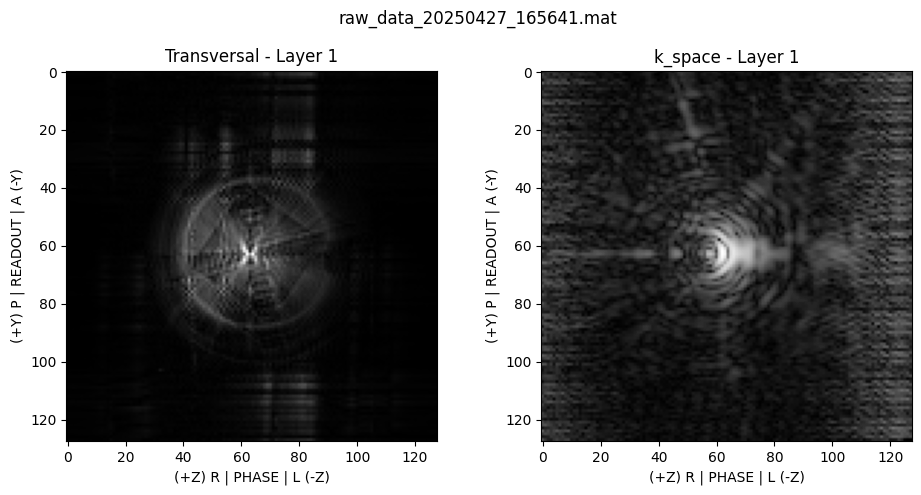

[{'widget': 'image',
  'data': array([[[0.99616745, 1.09076204, 1.1627896 , ..., 1.13567809,
           1.10880241, 1.10393113],
          [1.23947495, 1.30199043, 1.25764237, ..., 1.27799851,
           1.26516053, 1.30481708],
          [0.54136582, 0.49323894, 0.59419731, ..., 0.65914765,
           0.66280933, 0.63677524],
          ...,
          [0.74349713, 0.76456132, 0.78049857, ..., 0.73667037,
           0.83210417, 0.70959591],
          [0.05792556, 0.16943781, 0.16562211, ..., 0.09499245,
           0.04985185, 0.11281968],
          [0.84924257, 0.86373006, 0.90412793, ..., 0.889238  ,
           0.8146209 , 0.88800575]]]),
  'xLabel': '(+Z) R | PHASE | L (-Z)',
  'yLabel': '(+Y) P | READOUT | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.86892089, -1.77428243, -1.7114882 , ..., -1.66169547,
           -1.66270371, -1.58744826],
          [-1.5779482 , -1.77204045, -1.71274849, ..., -1.57853566,
           -1.77020

In [38]:

seq = SPRITER2dSEQ(nScans=3, larmorFreq=10.53584, rfExFA=90, repetitionTime=10,
                 rfExTime=400, echoTime=1, nPoints=1, riseTime=0.5,
                 SpoilingTimeAfterRising=0.5, fov=[150, 150], bandwidth=106.66666666666667,
                 SamplingPoints=[128, 128], shimming=[0.0015, 0.0019, 0.0005], txChannel=0, rxChannel=0,
                 axesOrientation=[1, 2, 0])

print(f"seq total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data_full']).max()}')
seq.sequenceAnalysis(mode='Standalone')
